# Cross-Autocorrelation Analysis Between Financial Assets

## Introduction
In this notebook, we will analyze the cross-autocorrelation between the returns of a reference financial asset and the lagged returns of other assets. This analysis helps identify whether the past returns of other assets have a predictive relationship with the current returns of the reference asset.

## 1. Importing Necessary Libraries

In [39]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf
from statsmodels.graphics.tsaplots import plot_acf

## 2. Defining the Assets for Analysis
We will select a reference asset and a list of other assets to compare against.

In [40]:
# Reference asset
ref_ticker = 'AAPL'  # Apple Inc.

# Other assets to compare
other_tickers = ['MSFT', 'GOOGL', 'AMZN']  # Microsoft, Alphabet, Amazon

# Combine all tickers
all_tickers = [ref_ticker] + other_tickers

## 3. Downloading the Adjusted Closing Prices
We will download the adjusted closing prices for all selected assets.

In [41]:
# Download data
prices = yf.download(all_tickers)['Adj Close'].dropna()

# View the last few rows
prices.tail()

[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2024-09-09 00:00:00+00:00,220.910004,175.399994,148.710007,405.720001
2024-09-10 00:00:00+00:00,220.110001,179.550003,148.660004,414.200012
2024-09-11 00:00:00+00:00,222.660004,184.520004,151.160004,423.040009
2024-09-12 00:00:00+00:00,222.770004,187.000000,154.690002,427.000000
2024-09-13 00:00:00+00:00,222.500000,186.490005,157.460007,430.589996


## 4. Calculating Daily Returns
Compute the daily returns for each asset.

In [42]:
# Calculate daily returns
returns = prices.pct_change().dropna()

# View the first few rows
returns.head()

Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2004-08-20 00:00:00+00:00,0.002930,0.022780,0.079430,0.002950
2004-08-23 00:00:00+00:00,0.009091,-0.001519,0.010064,0.004425
2004-08-24 00:00:00+00:00,0.027993,-0.010139,-0.041408,0.000000
2004-08-25 00:00:00+00:00,0.034429,0.032010,0.010776,0.011380
2004-08-26 00:00:00+00:00,0.048714,-0.002730,0.018019,-0.003993


## 5. Cross-Autocorrelation Analysis
We will analyze the cross-autocorrelation between the reference asset and each of the other assets over different time periods: the last 12 months, last 6 months, and last 3 months.

### 5.1 Defining the Time Periods

In [43]:
# Get the current date
end_date = returns.index.max()

# Define periods
periods = {
    'Last 12 Months': end_date - pd.DateOffset(months=12),
    'Last 6 Months': end_date - pd.DateOffset(months=6),
    'Last 3 Months': end_date - pd.DateOffset(months=3)
}

### 5.2 Calculating Cross-Correlation Functions
We will calculate and plot the cross-correlation functions between the reference asset and each other asset.

<ipython-input-44-94709e1c1a14>:29: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax.stem(range(num_lags), ccf_values, use_line_collection=True)


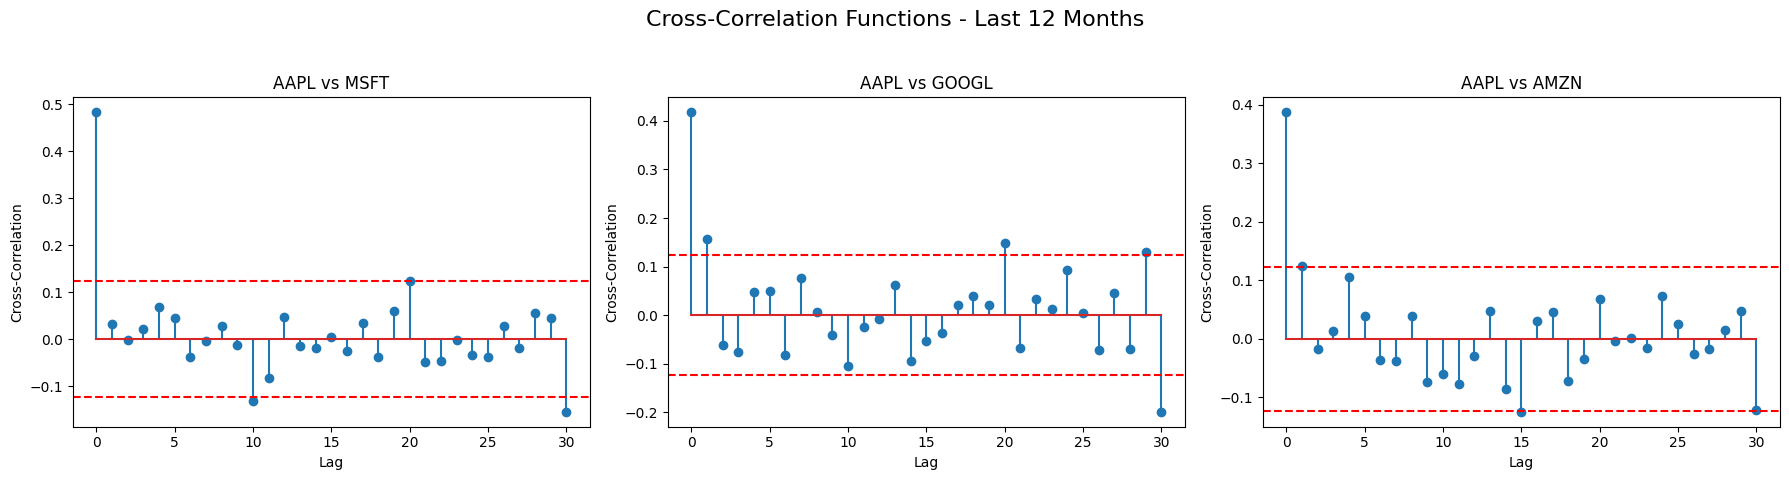

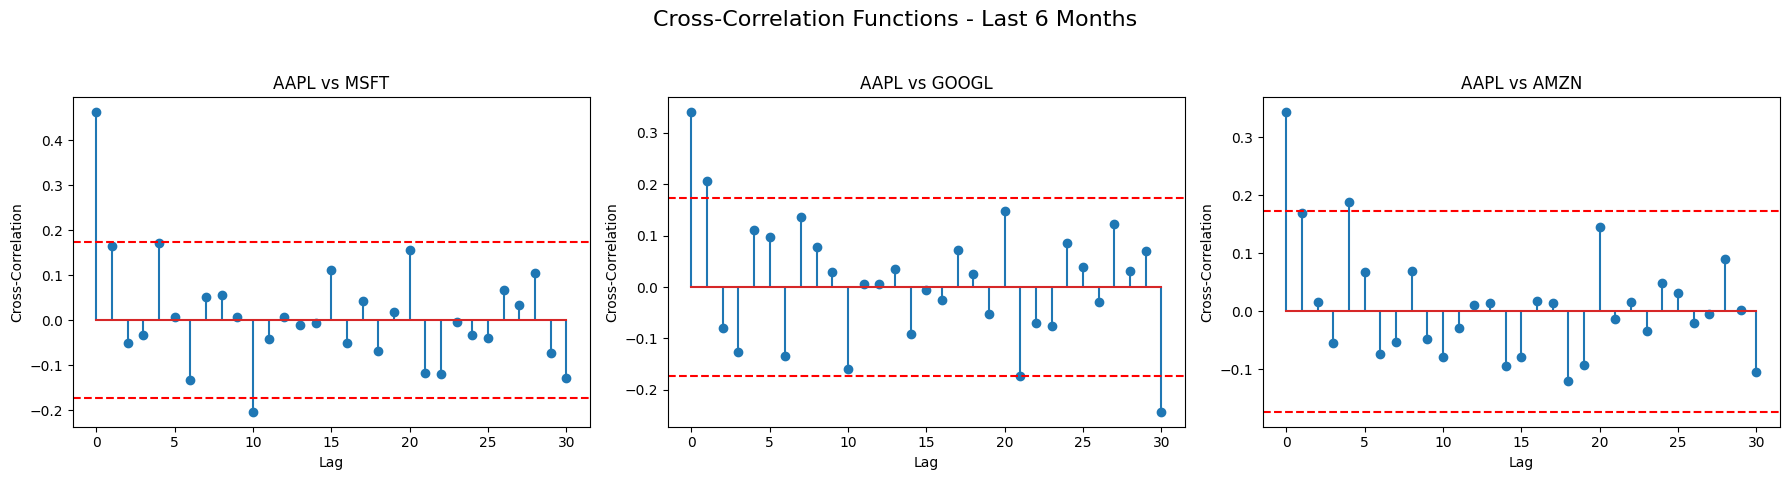

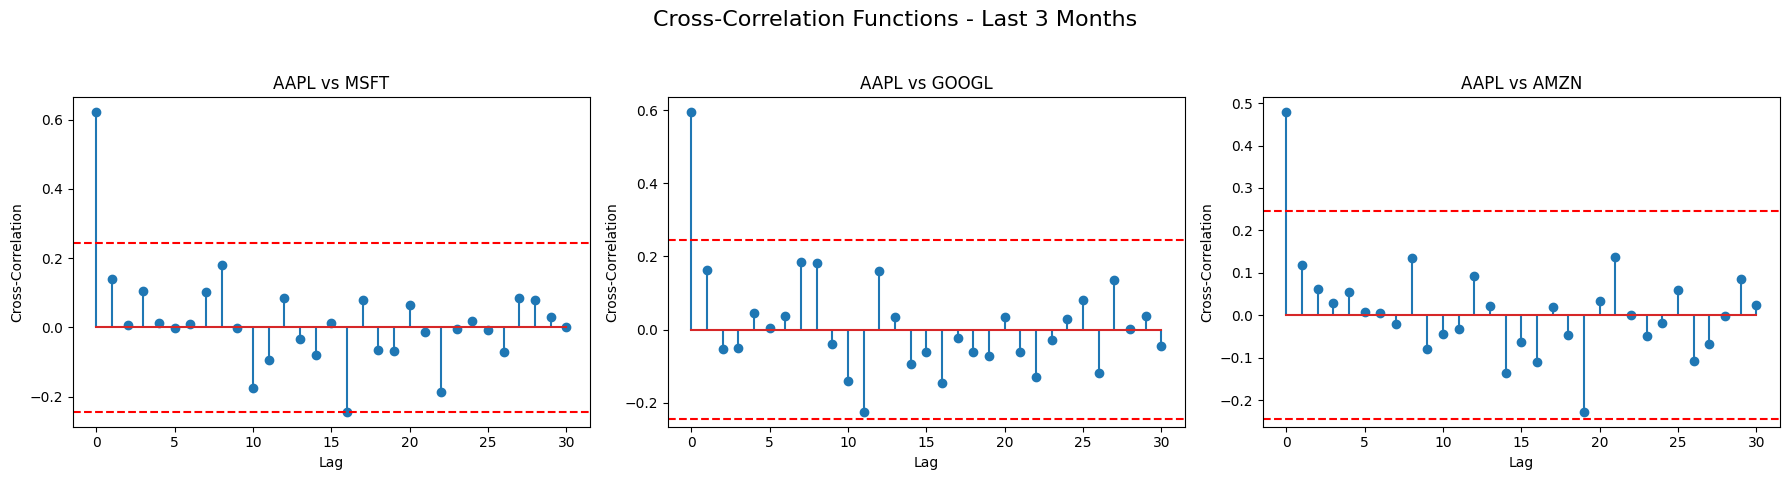

In [44]:
# Number of lags
num_lags = 31

# Iterate over each period
for period_name, start_date in periods.items():
    # Slice the returns for the given period
    period_returns = returns.loc[start_date:end_date]

    # Number of observations
    N = len(period_returns)

    # Extract returns for reference and other assets
    ref_returns = period_returns[ref_ticker]

    # Create subplots for each asset
    fig, axes = plt.subplots(1, len(other_tickers), figsize=(18, 5))
    fig.suptitle(f'Cross-Correlation Functions - {period_name}', fontsize=16)

    for ax, other_ticker in zip(axes, other_tickers):
        other_returns = period_returns[other_ticker]

        # Calculate cross-correlation
        ccf_values = ccf(ref_returns, other_returns, adjusted=False)[:num_lags]

        # Calculate 95% confidence intervals
        conf_int = 1.96 / np.sqrt(N)

        # Plot cross-correlation function
        ax.stem(range(num_lags), ccf_values, use_line_collection=True)

        # Plot confidence intervals
        ax.axhline(y=conf_int, linestyle='--', color='red')
        ax.axhline(y=-conf_int, linestyle='--', color='red')

        ax.set_title(f'{ref_ticker} vs {other_ticker}')
        ax.set_xlabel('Lag')
        ax.set_ylabel('Cross-Correlation')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 5.3 Creating a Cross-Correlation DataFrame
We will compile the cross-correlation coefficients into a DataFrame. Only the cross-correlation coefficients that exceed the 95% confidence interval are included.

In [45]:
# Initialize a dictionary to hold cross-correlations
crosscorr_dict = {}

# Number of lags (excluding lag 0)
num_lags = 30

# Calculate cross-correlations for each period and asset
for period_name, start_date in periods.items():
    # Slice the returns for the given period
    period_returns = returns.loc[start_date:end_date]

    # Number of observations
    N = len(period_returns)

    # Calculate the 95% confidence interval
    conf_int = 1.96 / np.sqrt(N)

    # Extract returns for reference asset
    ref_returns = period_returns[ref_ticker]

    for other_ticker in other_tickers:
        # Extract returns for the other asset
        other_returns = period_returns[other_ticker]

        # Calculate cross-correlation coefficients
        ccf_full = ccf(ref_returns, other_returns, adjusted=False)

        # Skip lag 0 and get the next num_lags coefficients
        ccf_values = ccf_full[1:num_lags+1]

        # Set coefficients that do not exceed the confidence interval to NaN
        significant_ccf_values = [
            ccf_val if abs(ccf_val) > conf_int else np.nan
            for ccf_val in ccf_values
        ]

        # Key for the dictionary
        key = f'{ref_ticker} vs {other_ticker} ({period_name})'

        # Store in the dictionary
        crosscorr_dict[key] = significant_ccf_values

# Create a DataFrame with lags starting from 1
df_crosscorr = pd.DataFrame(crosscorr_dict, index=range(1, num_lags+1))
df_crosscorr.index.name = 'Lag'

# Drop rows where all values are NaN (lags with no significant correlations)
df_crosscorr = df_crosscorr.dropna(axis=0, how='all')

# Drop columns where all values are NaN (asset pairs with no significant correlations)
df_crosscorr = df_crosscorr.dropna(axis=1, how='all')

# Display the DataFrame
df_crosscorr[df_crosscorr.index > 0]

,AAPL vs MSFT (Last 12 Months),AAPL vs GOOGL (Last 12 Months),AAPL vs AMZN (Last 12 Months),AAPL vs MSFT (Last 6 Months),AAPL vs GOOGL (Last 6 Months),AAPL vs AMZN (Last 6 Months)
Lag,,,,,,
1,NaN,0.156019,0.124804,NaN,0.205662,NaN
4,NaN,NaN,NaN,NaN,NaN,0.1877
10,-0.132175,NaN,NaN,-0.20367,NaN,NaN
15,NaN,NaN,-0.124642,NaN,NaN,NaN
20,NaN,0.147998,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,-0.174103,NaN
29,NaN,0.130513,NaN,NaN,NaN,NaN
30,-0.154231,-0.199101,NaN,NaN,-0.242868,NaN
